### 1. Data Loading and Preprocessing:
- Find and delete invalid and wrong-sized images (in hypertune notebook).
- Create custom dataset to access image, label, filename.
- Load the images from the four datasets: real_hands, VAE_hands, GAN_hands, and test_hands.
- Preprocess the images (resize, normalize, etc.) and split them into training and validation sets.
- Mean and std used for normalisation were found (in hypertune notebook)

### 2. Define the Neural Network Model:
- Create a CNN model with **dropout and batch normalisation**.
- Make sure the output layer has three neurons, corresponding to the three classes (0: real hand, 1: VAE hand, 2: GAN hand).

### 3. Hyperparameters
- Adjust hyperparameters or the model architecture based on validation performance.
- Loss Function (CrossEntropyLoss) and Optimizer (Adam).

### 4. Train and Evaluate:
- Evaluate the model on the validation set to monitor its performance.
- Plot accuracy and log loss to evaluate the performance.
- Plot the ConfusionMatrix to visualse the prediction.

### 5. Test the Model and Make Predictions:
- Train the model on the full dataset and evaluate on the test set.
- Save the result in certain format in edsml-hs1623_classified_hands.csv file

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

# Step 1: Data Loading and Preprocessing

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, label=0, transform=None):
        self.root_dir = root_dir
        self.label = label
        self.transform = transform

        # only select .jpeg files to avoid explicit files
        self.image_filenames = [filename for filename in os.listdir(root_dir) if filename.endswith(('.jpeg'))]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_filenames[idx])
        image = Image.open(img_name).convert('L')  # convert from 3 channels to 1 channel
        label = self.label                         # Assign different labels based on the dataset type
        filename = os.path.basename(img_name)      # keep the filename

        if self.transform:
            image = self.transform(image)
            
        return image, label, filename

In [3]:
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.271, std=0.297),  # Normalize to [-1, 1], find mean and std later
])

root_dir = "/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623"

# Load datasets
real_hands_dataset = CustomDataset(root_dir=f"{root_dir}/real_hands", label=0, transform=transform)
vae_hands_dataset = CustomDataset(root_dir=f"{root_dir}/VAE_hands", label=1, transform=transform)
gan_hands_dataset = CustomDataset(root_dir=f"{root_dir}/GAN_hands", label=2, transform=transform)
test_hands_dataset = CustomDataset(root_dir=f"{root_dir}/test_hands", transform=transform)

In [4]:
# Split real_hands dataset into training and validation sets
train_size = int(0.8 * len(real_hands_dataset))
val_size = len(real_hands_dataset) - train_size
real_train_dataset, real_val_dataset = random_split(real_hands_dataset, [train_size, val_size])

train_size = int(0.8 * len(vae_hands_dataset))
val_size = len(vae_hands_dataset) - train_size
vae_train_dataset, vae_val_dataset = random_split(vae_hands_dataset, [train_size, val_size])

train_size = int(0.8 * len(gan_hands_dataset))
val_size = len(gan_hands_dataset) - train_size
gan_train_dataset, gan_val_dataset = random_split(gan_hands_dataset, [train_size, val_size])

# Concatenate all training and validation datasets
train_dataset = ConcatDataset([real_train_dataset, vae_train_dataset, gan_train_dataset])
val_dataset = ConcatDataset([real_val_dataset, vae_val_dataset, gan_val_dataset])

# Note: No need to split test_hands_dataset as it's only used for testing.


# Create data loaders
batch_size = 64
test_batch_size = 1000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_hands_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

0 real_hand_411.jpeg


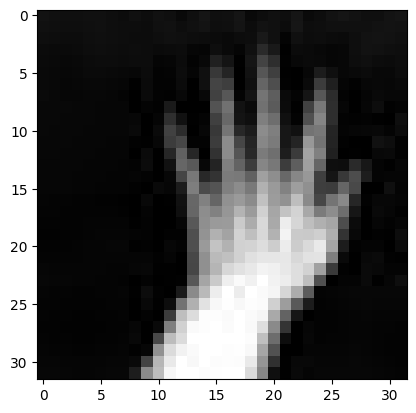

In [5]:
# Show one image and check
image, label, filename = train_dataset[0]
print(label, filename)
plt.imshow(image.squeeze(), cmap='gray')

# Step 2: Define the Neural Network Model

In [6]:
class CNNClassifier(nn.Module):
    # implement my own version of LeNet5 with dropout and batch normalisation
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.s2_bn = nn.BatchNorm2d(6)
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.c3_dr = nn.Dropout2d(p=0.5)
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Linear(16*5*5, 120)
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, 10)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.c1(x))
        x = self.act(self.s2_bn(self.s2(x)))  
        x = self.act(self.c3(x))
        x = self.c3_dr(x)
        x = self.act(self.s4(x))
        x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
        x = self.act(self.c5(x))
        x = self.act(self.f6(x))
        return self.output(x)

model = CNNClassifier()
print(model)

CNNClassifier(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (s2_bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (c3_dr): Dropout2d(p=0.5, inplace=False)
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
)


# Step3: Hyperparameters

In [35]:
# Select hyperparameters
seed = 42
lr = 1e-3
batch_size = 64
test_batch_size = 1000
n_epochs = 100

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

# Step4: Train and Evaluate

In [29]:
# Provided Train, Validation and Evaluate Functions

device = 'cpu'  # It's not computationally expensive, so I decided to run on my local environment

def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y, _ in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 32, 32))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y, _ in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 32, 32))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y, _ in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 32, 32))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

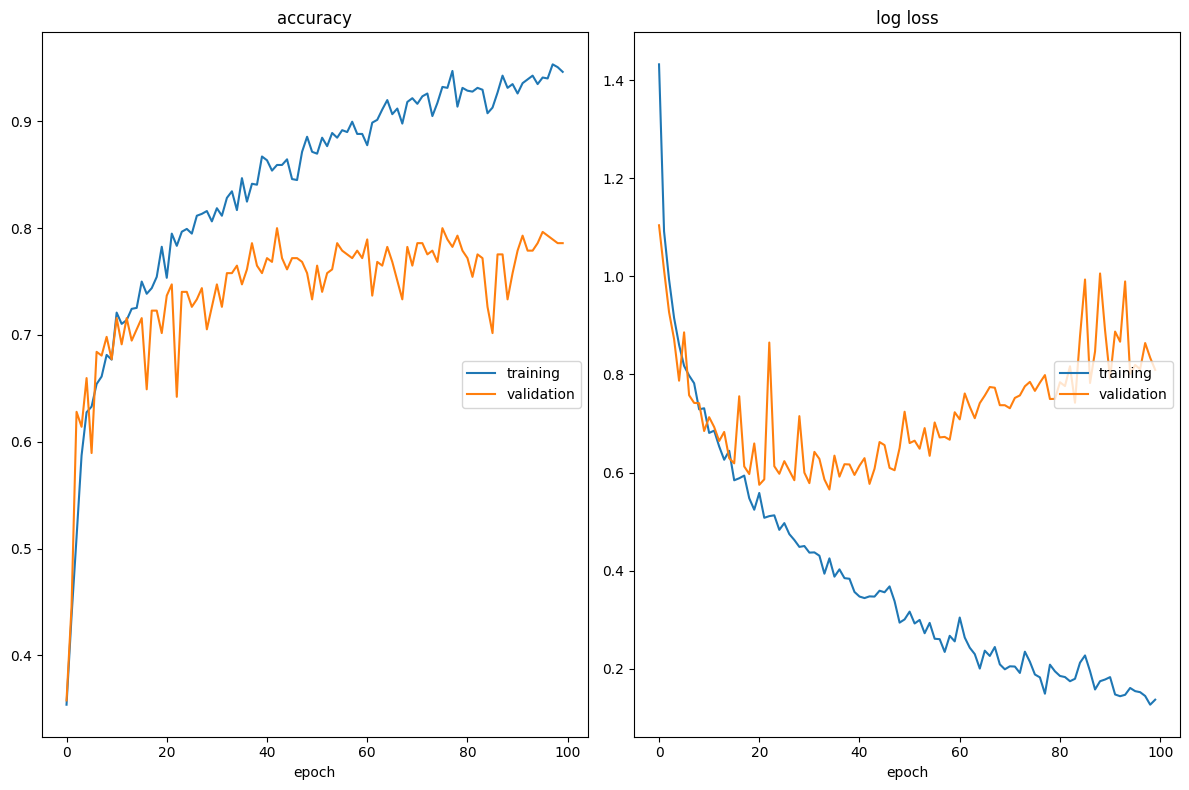

accuracy
	training         	 (min:    0.354, max:    0.953, cur:    0.946)
	validation       	 (min:    0.358, max:    0.800, cur:    0.786)
log loss
	training         	 (min:    0.127, max:    1.432, cur:    0.137)
	validation       	 (min:    0.565, max:    1.104, cur:    0.809)


In [36]:
def train_model():
    set_seed(seed)
    model = CNNClassifier().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_hands_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

    liveloss = PlotLosses()
    for epoch in range(n_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

        logs['' + 'log loss'] = train_loss.item()
        logs['' + 'accuracy'] = train_accuracy.item()

        validation_loss, validation_accuracy = validate(model, criterion, val_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        logs['val_' + 'accuracy'] = validation_accuracy.item()

        liveloss.update(logs)
        liveloss.draw()

    return model

model = train_model()

In [37]:
validation_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0) # create a validation_loader
y_pred, y_gt = evaluate(model, validation_loader) # generate predictions and ground truths by evaluating the model

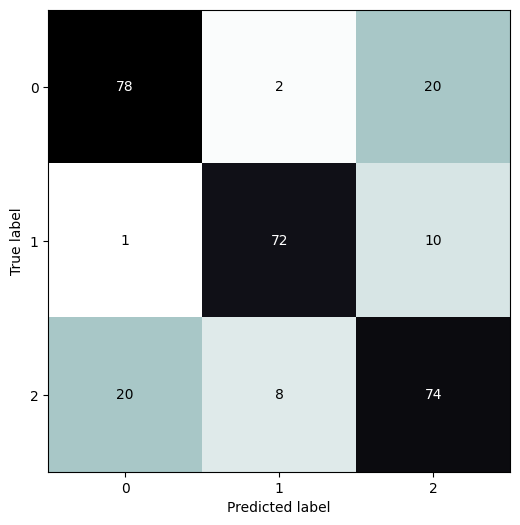

In [38]:
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_gt, y_pred, ax=ax, colorbar=False, cmap='bone_r')
plt.show()

# Step5: Test the model and Make Predictions

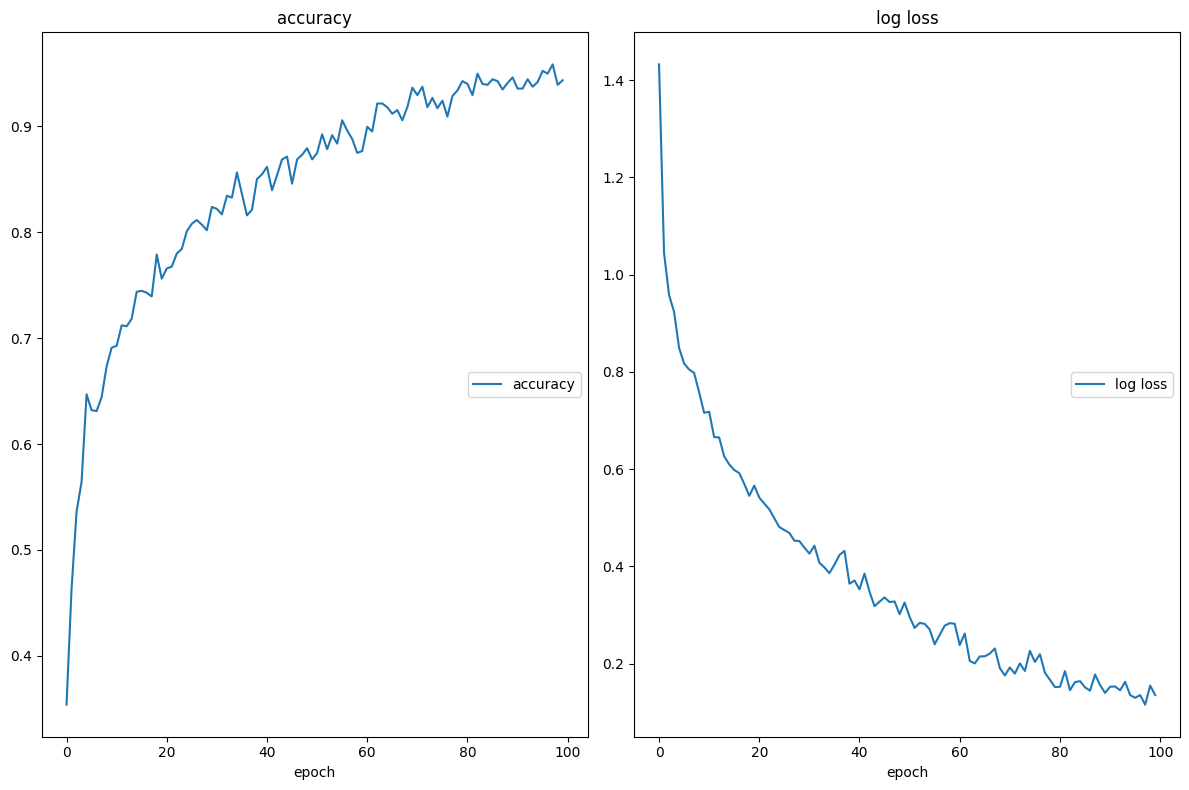

accuracy
	accuracy         	 (min:    0.354, max:    0.959, cur:    0.944)
log loss
	log loss         	 (min:    0.115, max:    1.432, cur:    0.135)
Avg. Test Loss: 10.665  Avg. Test Accuracy: 0.294


In [39]:
# Train the model on the full dataset and evaluate on the test set
set_seed(seed)
model = CNNClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

liveloss = PlotLosses()

n_epochs = 100
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.


val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_hands_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())

In [40]:
# Make predictions
model.eval()
all_predictions = []
filenames = []

with torch.no_grad():
    for image, _, filename in test_loader:
        image = image.to(device)
        outputs = model(image)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.cpu().numpy())
        filenames.extend(filename)

In [41]:
# Create a DataFrame to store file paths and predicted classes
result_df = pd.DataFrame({'Filename': filenames, 'Predicted_Class': all_predictions})
result_df = result_df.sort_values(by='Filename')

# Save the DataFrame to a CSV file
result_df.to_csv("/Users/hs1623/Imperial/dlmodule-coursework-2-edsml-hs1623/edsml-hs1623_classified_hands.csv", index=False)